# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

In [6]:
data_size = int(1e3)

In [7]:
# Data points
t  = np.random.uniform(np.pi, 10*np.pi, data_size)
X_array = np.stack((t,), axis=0)
f      = 0.784
alpha0 = 1/9.89
phi    = 0.997
y_array = np.exp(-t*alpha0)*np.cos(f*t + phi)

# One of many symbolic solutions:
target_program_str = ["mul", "exp", "neg", "mul", "t", "alpha0", "cos", "add", "mul", "f", "t", "phi",]
print(len(target_program_str))


12


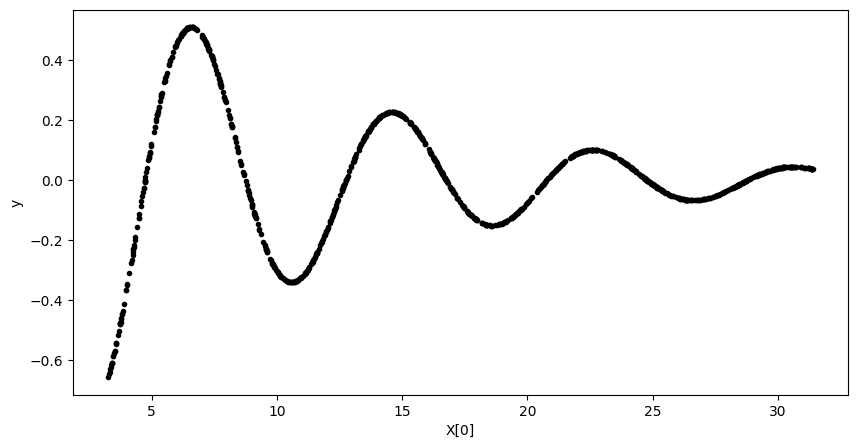

In [8]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [9]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array( 1.   )).to(DEVICE)
#f      = torch.tensor(np.array( f    )).to(DEVICE)
#phi    = torch.tensor(np.array( phi  )).to(DEVICE)

## Run config

### Library config

In [10]:
# [length, mass, time]
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"t" : 0         ,},
                "input_var_units"      : {"t" : [0, 0, 1] ,},
                "input_var_complexity" : {"t" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"f"               , "alpha0"               , "phi"               , },
                "free_constants_init_val"   : {"f" : 1.          , "alpha0" : 1/10.       , "phi" : 1.          , },
                "free_constants_units"      : {"f" : [0, 0, -1]  , "alpha0" : [0, 0, -1]  , "phi" : [0, 0, 0]   , },
                "free_constants_complexity" : {"f" : 1.          , "alpha0" : 1.          , "phi" : 1.          , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, 0, 0],
                  "superparent_name"  : "F",
                }


### Learning config

In [11]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True, # PHYSICALITY
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [12]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [13]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [14]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 5,
                        'tol'     : 1e-6,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [15]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [16]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [17]:
save_path_training_curves = 'harmonic_curves.png'
save_path_log             = 'harmonic.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [18]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

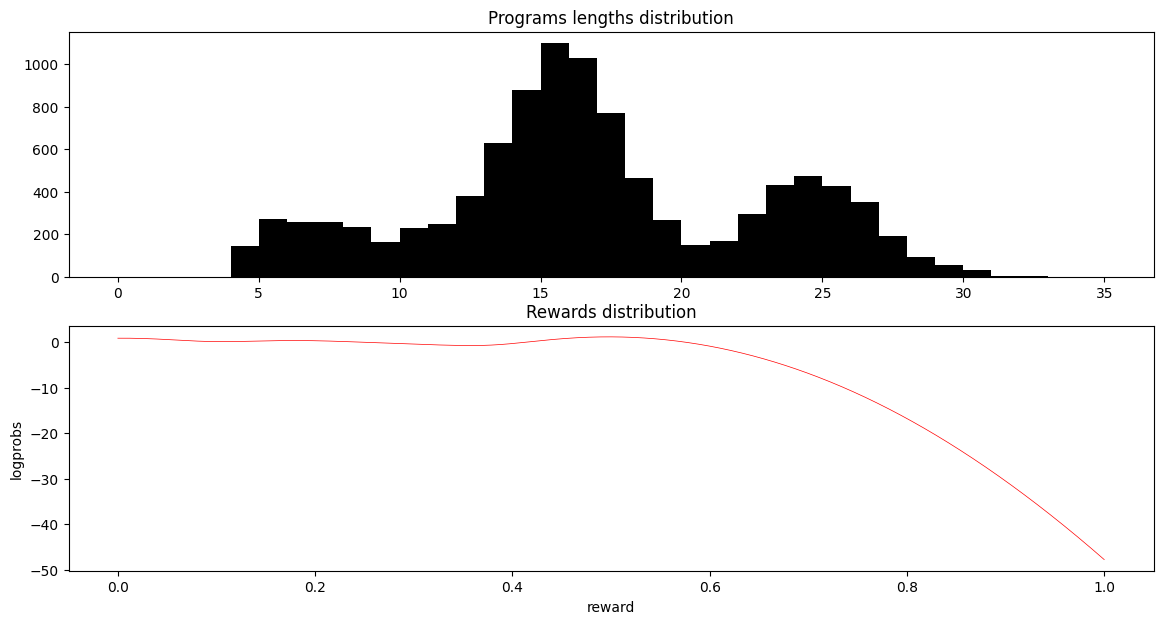

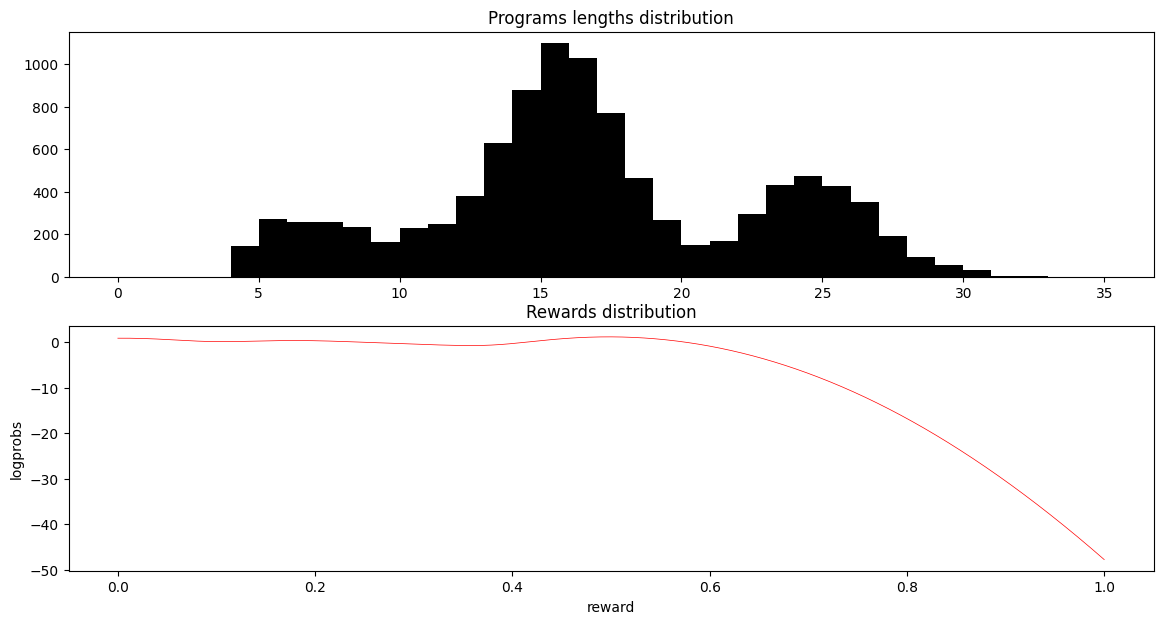

In [19]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


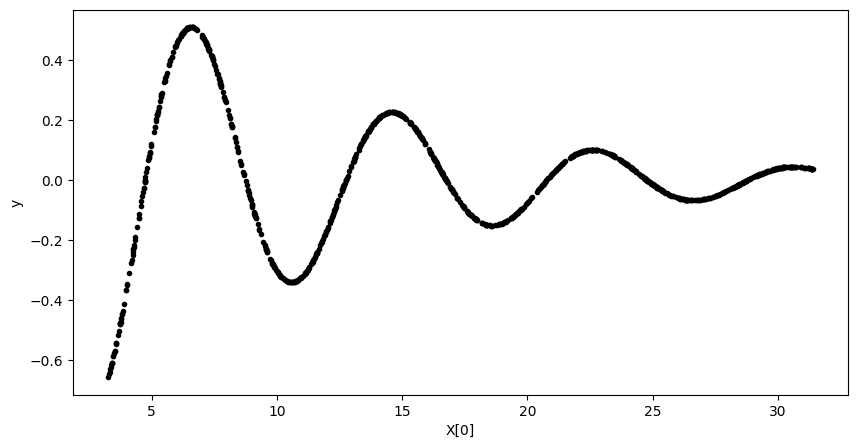

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'neg': 7, 'exp': 8, 'log': 9, 'sin': 10, 'cos': 11, '1': 12, 'alpha0': 13, 'f': 14, 'phi': 15, 't': 16}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt neg exp log sin cos 1 alpha0 f phi t F dummy
 -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'neg', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'neg', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([1, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs --------------

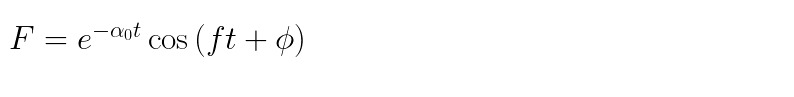

Simplified expression:


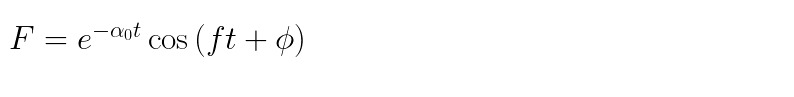

free const opti time = 8.235583 ms


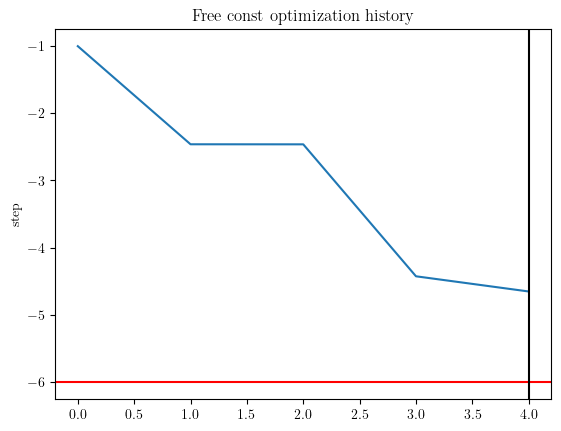

Ideal reward : 0.9999839030555273


In [20]:
target_program = benchmark.sanity_check(X, y, run_config, 
                                        target_program_str = target_program_str,
                                        expected_ideal_reward = 0.9999,
                                       )

## Run

In [21]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999, 
                                stop_after_n_epochs = 10)

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 9.30 s

Overall best  at R=0.547757
-> Raw expression : 
                         2
⎛                      2⎞ 
⎜   ⎛    ⎛          2⎞⎞ ⎟ 
⎜   ⎜    ⎜    ⎛ 1  ⎞ ⎟⎟ ⎟ 
⎜   ⎜ sin⎜φ + ⎜────⎟ ⎟⎟ ⎟ 
⎜   ⎜    ⎝    ⎝α₀⋅t⎠ ⎠⎟ ⎟ 
⎝φ⋅-⎝ℯ                ⎠ ⎠ 

Best of epoch at R=0.547757
-> Raw expression : 
                         2
⎛                      2⎞ 
⎜   ⎛    ⎛          2⎞⎞ ⎟ 
⎜   ⎜    ⎜    ⎛ 1  ⎞ ⎟⎟ ⎟ 
⎜   ⎜ sin⎜φ + ⎜────⎟ ⎟⎟ ⎟ 
⎜   ⎜    ⎝    ⎝α₀⋅t⎠ ⎠⎟ ⎟ 
⎝φ⋅-⎝ℯ                ⎠ ⎠ 




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00001 ===========
-> Time 80.78 s

Overall best  at R=0.547757
-> Raw expression : 
                         2
⎛                      2⎞ 
⎜   ⎛    ⎛          2⎞⎞ ⎟ 
⎜   ⎜    ⎜    ⎛ 1  ⎞ ⎟⎟ ⎟ 
⎜   ⎜ sin⎜φ + ⎜────⎟ ⎟⎟ ⎟ 
⎜   ⎜    ⎝    ⎝α₀⋅t⎠ ⎠⎟ ⎟ 
⎝φ⋅-⎝ℯ                ⎠ ⎠ 

Best of epoch at R=0.537830
-> Raw expression : 
   ⎛     0.5    ⎞              
   ⎜⎛-f ⎞       ⎟              
log⎜⎜───⎟    - 1⎟⋅sin(α₀⋅t - φ)
   ⎝⎝ α₀⎠       ⎠              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00002 ===========
-> Time 77.06 s

Overall best  at R=0.625015
-> Raw expression : 
     ⎛               1        ⎞
φ⋅sin⎜-α₀⋅t + ────────────────⎟
     ⎜           ⎛-(-α₀ - f) ⎞⎟
     ⎜        log⎜───────────⎟⎟
     ⎝           ⎝     α₀    ⎠⎠

Best of epoch at R=0.625015
-> Raw expression : 
     ⎛               1        ⎞
φ⋅sin⎜-α₀⋅t + ────────────────⎟
     ⎜           ⎛-(-α₀ - f) ⎞⎟
     ⎜        log⎜───────────⎟⎟
     ⎝           ⎝     α₀    ⎠⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00003 ===========
-> Time 78.37 s

Overall best  at R=0.625015
-> Raw expression : 
     ⎛               1        ⎞
φ⋅sin⎜-α₀⋅t + ────────────────⎟
     ⎜           ⎛-(-α₀ - f) ⎞⎟
     ⎜        log⎜───────────⎟⎟
     ⎝           ⎝     α₀    ⎠⎠

Best of epoch at R=0.600880
-> Raw expression : 
      ⎛                             2⎞
      ⎜(φ + log(φ⋅t⋅(-α₀ + α₀ + f))) ⎟
α₀⋅cos⎜──────────────────────────────⎟
      ⎝              φ               ⎠
──────────────────────────────────────
                  f                   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00004 ===========
-> Time 79.20 s

Overall best  at R=0.628261
-> Raw expression : 
t⋅-1⋅sin(-α₀⋅t - φ - φ + 1)⋅1
─────────────────────────────
                2            
            α₀⋅t             

Best of epoch at R=0.628261
-> Raw expression : 
t⋅-1⋅sin(-α₀⋅t - φ - φ + 1)⋅1
─────────────────────────────
                2            
            α₀⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00005 ===========
-> Time 82.84 s

Overall best  at R=0.628261
-> Raw expression : 
t⋅-1⋅sin(-α₀⋅t - φ - φ + 1)⋅1
─────────────────────────────
                2            
            α₀⋅t             

Best of epoch at R=0.590485
-> Raw expression : 
   ⎛     1 ⎞           
sin⎜1 + ───⎟⋅cos(t⋅f⋅1)
   ⎜     -φ⎟           
   ⎝    ℯ  ⎠           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 8456 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 8507 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 8520 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 8542 -> r 

=========== Epoch 00006 ===========
-> Time 80.62 s

Overall best  at R=0.628261
-> Raw expression : 
t⋅-1⋅sin(-α₀⋅t - φ - φ + 1)⋅1
─────────────────────────────
                2            
            α₀⋅t             

Best of epoch at R=0.614629
-> Raw expression : 
        ⎛  ⎛       1 ⎞    ⎞
-φ⋅φ⋅sin⎜- ⎜f⋅t + ───⎟ - 1⎟
        ⎝  ⎝      1⋅φ⎠    ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00007 ===========
-> Time 87.08 s

Overall best  at R=0.636570
-> Raw expression : 
          1      
-1 + ────────────
      -cos(α₀⋅t) 
      ───────────
        α₀⋅t - φ 
     ℯ           

Best of epoch at R=0.636570
-> Raw expression : 
          1      
-1 + ────────────
      -cos(α₀⋅t) 
      ───────────
        α₀⋅t - φ 
     ℯ           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00008 ===========
-> Time 83.34 s

Overall best  at R=0.726390
-> Raw expression : 
               1      
-cos(φ) + ────────────
                -α₀   
          φ⋅t⋅────────
              sin(f⋅t)

Best of epoch at R=0.726390
-> Raw expression : 
               1      
-cos(φ) + ────────────
                -α₀   
          φ⋅t⋅────────
              sin(f⋅t)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00009 ===========
-> Time 92.84 s

Overall best  at R=0.726390
-> Raw expression : 
               1      
-cos(φ) + ────────────
                -α₀   
          φ⋅t⋅────────
              sin(f⋅t)

Best of epoch at R=0.627314
-> Raw expression : 
                ⎛   ⎛       1  ⎞⎞
-φ + φ + φ + sin⎜α₀⋅⎜-t + ─────⎟⎟
                ⎜   ⎜         t⎟⎟
                ⎜   ⎜         ─⎟⎟
                ⎜   ⎜         t⎟⎟
                ⎝   ⎝     α₀⋅ℯ ⎠⎠
─────────────────────────────────
               α₀⋅t              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00010 ===========
-> Time 85.65 s

Overall best  at R=0.796622
-> Raw expression : 
        α₀       
─────────────────
⎛      f⋅t      ⎞
⎜───────────────⎟
⎜⎛sin(α₀⋅t - φ)⎞⎟
⎜⎜─────────────⎟⎟
⎝⎝      α₀     ⎠⎠

Best of epoch at R=0.796622
-> Raw expression : 
        α₀       
─────────────────
⎛      f⋅t      ⎞
⎜───────────────⎟
⎜⎛sin(α₀⋅t - φ)⎞⎟
⎜⎜─────────────⎟⎟
⎝⎝      α₀     ⎠⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00011 ===========
-> Time 85.62 s

Overall best  at R=0.796622
-> Raw expression : 
        α₀       
─────────────────
⎛      f⋅t      ⎞
⎜───────────────⎟
⎜⎛sin(α₀⋅t - φ)⎞⎟
⎜⎜─────────────⎟⎟
⎝⎝      α₀     ⎠⎠

Best of epoch at R=0.760333
-> Raw expression : 
    t⋅-sin(f⋅t)
φ + ───────────
         α₀⋅t  
      t⋅ℯ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00012 ===========
-> Time 83.98 s

Overall best  at R=0.796622
-> Raw expression : 
        α₀       
─────────────────
⎛      f⋅t      ⎞
⎜───────────────⎟
⎜⎛sin(α₀⋅t - φ)⎞⎟
⎜⎜─────────────⎟⎟
⎝⎝      α₀     ⎠⎠

Best of epoch at R=0.747612
-> Raw expression : 
  sin(α₀⋅t)   
──────────────
          ⎛ φ⎞
α₀⋅φ⋅t⋅cos⎝ℯ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00013 ===========
-> Time 84.95 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00014 ===========
-> Time 80.65 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.749071
-> Raw expression : 
      sin(f⋅-t) 
-φ + ───────────
               t
           φ + ─
               t
     α₀⋅t⋅ℯ     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00015 ===========
-> Time 79.61 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.749086
-> Raw expression : 
-φ⋅sin(f⋅t) - sin(-α₀⋅t)
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00016 ===========
-> Time 77.94 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.747612
-> Raw expression : 
      sin(f⋅t)      
────────────────────
   ⎛        0.5    ⎞
   ⎜   ⎛ -φ⎞       ⎟
-t⋅⎝α₀⋅⎝ℯ  ⎠    + f⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00017 ===========
-> Time 80.08 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.848019
-> Raw expression : 
   ⎛  ⎛        -φ + φ    ⎞⎞
   ⎜f⋅⎝- α₀⋅t⋅ℯ       + φ⎠⎟
cos⎜──────────────────────⎟
   ⎝          α₀          ⎠
───────────────────────────
            α₀⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00018 ===========
-> Time 77.83 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.666953
-> Raw expression : 
   cos(f⋅t)   
──────────────
f⋅φ⋅t + cos(φ)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00019 ===========
-> Time 78.27 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.747612
-> Raw expression : 
 sin(-f⋅t) 
───────────
α₀⋅t⋅cos(φ)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00020 ===========
-> Time 76.30 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.667121
-> Raw expression : 
         cos(- -f⋅t)
sin(φ) - ───────────
            -α₀⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00021 ===========
-> Time 77.50 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.829257
-> Raw expression : 
(f⋅t - -φ)⋅sin(-α₀⋅t + φ)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00022 ===========
-> Time 77.56 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.853885
-> Raw expression : 
   ⎛       α₀⎞
cos⎜-f⋅t - ──⎟
   ⎝       α₀⎠
──────────────
     α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00023 ===========
-> Time 73.55 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.757962
-> Raw expression : 
sin(-φ⋅- -f⋅t)
──────────────
     α₀⋅t     
    ℯ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00024 ===========
-> Time 72.99 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.750484
-> Raw expression : 
sin(-f⋅φ⋅t - φ)
───────────────
      -f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00025 ===========
-> Time 72.36 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.857903
-> Raw expression : 
sin(-f⋅t + φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00026 ===========
-> Time 68.12 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
   ⎛               φ⎞
cos⎝t⋅(-α₀ + f) + ℯ ⎠
─────────────────────
         f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00027 ===========
-> Time 66.82 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
       ⎛     α₀⋅-f⋅t⎞ 
-α₀⋅sin⎜-φ + ───────⎟ 
       ⎝        α₀  ⎠ 
──────────────────────
        t⋅-f⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00028 ===========
-> Time 70.09 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(φ⋅(f⋅t + φ + φ⋅φ) + φ)
──────────────────────────
          α₀⋅φ⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00029 ===========
-> Time 66.28 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.860974
-> Raw expression : 
   ⎛f⋅-α₀⋅(f⋅t + φ)⎞
cos⎜───────────────⎟
   ⎝      α₀⋅f     ⎠
────────────────────
        α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00030 ===========
-> Time 64.22 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.747612
-> Raw expression : 
sin(-α₀⋅-t - f⋅t)
─────────────────
       f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00031 ===========
-> Time 62.66 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.858545
-> Raw expression : 
sin(α₀⋅t + f⋅t - φ)
───────────────────
        f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00032 ===========
-> Time 61.03 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.860794
-> Raw expression : 
    ⎛-f⋅(α₀⋅t + φ) ⎞ 
-sin⎜──────────────⎟ 
    ⎝      α₀      ⎠ 
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00033 ===========
-> Time 60.91 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅-sin(-α₀⋅t + φ)
──────────────────
      f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00034 ===========
-> Time 61.27 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
    ⎛    -f + -t⋅-f⋅f⎞ 
-sin⎜φ + ────────────⎟ 
    ⎝         f      ⎠ 
───────────────────────
          α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00035 ===========
-> Time 61.25 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
   ⎛     -f     ⎞
sin⎜-f⋅t⋅─── + φ⎟
   ⎝      f     ⎠
─────────────────
       α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00036 ===========
-> Time 60.67 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
sin(-f⋅-t - -φ)
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00037 ===========
-> Time 61.76 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.840743
-> Raw expression : 
cos(-f⋅φ⋅t - φ)
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00038 ===========
-> Time 60.43 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(f⋅t + φ)
──────────────
     α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00039 ===========
-> Time 69.29 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.839664
-> Raw expression : 
- -sin(α₀⋅t - φ) 
─────────────────
       f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00040 ===========
-> Time 62.44 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
      ⎛-α₀⋅f⋅-t    ⎞
α₀⋅sin⎜──────── + φ⎟
      ⎝   α₀       ⎠
────────────────────
      α₀⋅α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00041 ===========
-> Time 61.70 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
-sin(--f⋅t - φ) 
────────────────
      α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00042 ===========
-> Time 59.99 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
  -sin(--α₀⋅t + φ) 
f⋅─────────────────
          t        
───────────────────
       -α₀⋅α₀      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00043 ===========
-> Time 60.83 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
 -f⋅sin(--f⋅t - φ)  
-────────────────── 
         t          
────────────────────
       -α₀⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00044 ===========
-> Time 60.29 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.859765
-> Raw expression : 
-cos(-φ - t⋅(α₀ - f)) 
──────────────────────
        f⋅φ⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00045 ===========
-> Time 59.78 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅cos(-f⋅t - φ⋅φ)
─────────────────
       α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00046 ===========
-> Time 59.81 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
     ⎛    ⎛    φ⎞⎞
φ⋅cos⎜f⋅φ⋅⎜t + ─⎟⎟
     ⎝    ⎝    f⎠⎠
──────────────────
       α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00047 ===========
-> Time 60.07 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861025
-> Raw expression : 
sin(- -φ⋅φ⋅(f⋅t + φ))
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00048 ===========
-> Time 58.77 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
-f⋅sin(-f⋅t - φ)
────────────────
     α₀⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00049 ===========
-> Time 58.57 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
φ⋅sin(-f⋅-t + φ)
────────────────
     α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00050 ===========
-> Time 59.50 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.860870
-> Raw expression : 
φ⋅sin(-f⋅t + φ + φ)
───────────────────
        α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00051 ===========
-> Time 60.13 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(f⋅t - -φ⋅φ)
──────────────────
      f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00052 ===========
-> Time 61.02 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(f⋅t + φ + φ)
───────────────────
      f⋅f⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00053 ===========
-> Time 57.63 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
⎛-sin(-α₀⋅t - f⋅t - φ) ⎞
⎜──────────────────────⎟
⎝          t           ⎠
────────────────────────
           f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00054 ===========
-> Time 58.46 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(f⋅t + φ)
──────────────
     α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00055 ===========
-> Time 56.90 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
t⋅sin(-f⋅t + φ)
───────────────
     α₀⋅t⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00056 ===========
-> Time 66.15 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅φ⋅-cos(f⋅-φ⋅t + φ + φ)
────────────────────────
          α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00057 ===========
-> Time 59.04 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(-f⋅t + φ)
───────────────
     α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00058 ===========
-> Time 58.89 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
  -cos(f⋅t - 2⋅φ) 
φ⋅────────────────
         t        
──────────────────
        α₀        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00059 ===========
-> Time 58.56 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(--f⋅-t + φ)
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00060 ===========
-> Time 58.08 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
φ⋅φ⋅t⋅cos(-f⋅t - φ)
───────────────────
       α₀⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00061 ===========
-> Time 58.02 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861026
-> Raw expression : 
φ⋅φ⋅sin(-f⋅-φ⋅t + φ + φ)
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00062 ===========
-> Time 55.31 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
     -f⋅sin(f⋅t + φ) 
α₀⋅φ⋅────────────────
          f⋅f⋅f      
─────────────────────
          t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00063 ===========
-> Time 51.46 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅t⋅sin(-f⋅t + φ)
─────────────────
     α₀⋅f⋅t⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00064 ===========
-> Time 55.33 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅φ⋅cos(α₀⋅t + φ)
─────────────────
    α₀⋅α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00065 ===========
-> Time 57.30 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(-f⋅-t + φ + φ)
────────────────────
        α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00066 ===========
-> Time 56.82 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅t⋅cos(-f⋅t + φ)
──────────────────
     f⋅f⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00067 ===========
-> Time 56.31 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅φ⋅cos(f⋅t + φ)
────────────────
     α₀⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00068 ===========
-> Time 57.85 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
  - -sin(-f⋅t + φ) 
f⋅─────────────────
        α₀⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00069 ===========
-> Time 56.14 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅t⋅sin(--f⋅t + φ)
───────────────────
      f⋅f⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00070 ===========
-> Time 54.77 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅t⋅sin(-f⋅t + φ)
─────────────────
     α₀⋅f⋅t⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00071 ===========
-> Time 54.94 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅φ⋅-cos(-f⋅t + φ)
───────────────────
      f⋅f⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00072 ===========
-> Time 54.18 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅φ⋅t⋅sin(-f⋅t + φ)
───────────────────
     φ⋅t⋅t⋅α₀⋅f    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00073 ===========
-> Time 55.03 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅-sin(f⋅t - φ)
───────────────
     α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00074 ===========
-> Time 54.89 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅t⋅sin(f⋅t + φ)
────────────────
     α₀⋅t⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00075 ===========
-> Time 55.84 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(--f⋅-t + φ)
─────────────────
      α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00076 ===========
-> Time 68.59 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅α₀⋅φ⋅sin(f⋅t + φ)
────────────────────
      f⋅t⋅f⋅f       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00077 ===========
-> Time 54.73 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(f⋅t + φ)
───────────────
     f⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00078 ===========
-> Time 55.66 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅f⋅sin(--f⋅t + φ + φ)
───────────────────────
       α₀⋅α₀⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00079 ===========
-> Time 56.54 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
t⋅sin(f⋅t - φ)
──────────────
   α₀⋅-t⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00080 ===========
-> Time 55.88 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅-sin(-f⋅-t - φ)
─────────────────
      α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00081 ===========
-> Time 55.79 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(--f⋅-t + φ)
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00082 ===========
-> Time 55.92 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅-sin(-f⋅t - φ)
─────────────────
     -t⋅-f⋅f     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00083 ===========
-> Time 56.04 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅-sin(-f⋅t - φ)
─────────────────
      f⋅f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00084 ===========
-> Time 55.35 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅t⋅sin(f⋅t + φ⋅φ)
──────────────────
      α₀⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00085 ===========
-> Time 54.55 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
-α₀⋅f⋅sin(-f⋅t - φ) 
────────────────────
      f⋅f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00086 ===========
-> Time 54.11 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅sin(-f⋅-t + φ + φ)
────────────────────
       α₀⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00087 ===========
-> Time 53.15 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅sin(--f⋅-t + φ)
─────────────────
      α₀⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00088 ===========
-> Time 52.73 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅φ⋅t⋅sin(f⋅t + -φ⋅-φ)
──────────────────────
       α₀⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00089 ===========
-> Time 53.45 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅-sin(-f⋅t - φ)
─────────────────
      f⋅f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00090 ===========
-> Time 53.71 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(--f⋅t + φ)
─────────────────
      f⋅f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00091 ===========
-> Time 54.05 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
       - -sin(f⋅t + φ + φ) 
α₀⋅f⋅t⋅────────────────────
               f⋅t         
───────────────────────────
          α₀⋅α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00092 ===========
-> Time 51.53 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅t⋅sin(f⋅t + φ⋅φ)
───────────────────
      f⋅f⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00093 ===========
-> Time 52.03 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(--f⋅t + φ + φ)
─────────────────────
       α₀⋅α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00094 ===========
-> Time 50.41 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅sin(φ + φ - t⋅(α₀ + f))
─────────────────────────
          t⋅-f⋅f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00095 ===========
-> Time 52.98 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
-f⋅-t⋅sin(f⋅t + φ + φ) 
───────────────────────
        α₀⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00096 ===========
-> Time 52.30 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅t⋅sin(f⋅t + φ + φ)
────────────────────
      α₀⋅f⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00097 ===========
-> Time 53.08 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(f⋅t - -φ⋅φ + φ⋅φ)
─────────────────────
        α₀⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00098 ===========
-> Time 53.70 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
   ⎛       φ⋅φ⎞
sin⎝f⋅t + ℯ   ⎠
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00099 ===========
-> Time 52.88 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅f⋅sin(f⋅t + φ + φ)
────────────────────
      f⋅t⋅α₀⋅f      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00100 ===========
-> Time 53.90 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(f⋅t + φ + φ)
───────────────────
      α₀⋅α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00101 ===========
-> Time 54.23 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅sin(-f⋅-t + φ + φ)
────────────────────
       α₀⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00102 ===========
-> Time 53.29 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
f⋅t⋅-sin(f⋅t + φ + φ)
─────────────────────
      α₀⋅f⋅-t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00103 ===========
-> Time 53.07 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
⎛-sin(-α₀⋅t - f⋅t - φ) ⎞
⎜──────────────────────⎟
⎝          f           ⎠
────────────────────────
           t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00104 ===========
-> Time 53.41 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(f⋅t - φ + φ⋅φ + φ)
─────────────────────────
          f⋅f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00105 ===========
-> Time 53.22 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
t⋅sin(f⋅t + φ + φ)
──────────────────
      α₀⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00106 ===========
-> Time 52.97 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(α₀⋅t - f⋅-t - 2⋅φ)
──────────────────────
         f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00107 ===========
-> Time 53.47 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅sin(-f⋅-t + φ + φ)
─────────────────────
       α₀⋅α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00108 ===========
-> Time 53.08 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
t⋅sin(f⋅t + φ + φ)
──────────────────
      α₀⋅t⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00109 ===========
-> Time 53.23 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅sin(φ + -f⋅-t + φ)
────────────────────
       α₀⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00110 ===========
-> Time 53.20 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
φ⋅φ⋅-sin(f⋅t + φ + φ + φ + φ + φ + φ)
─────────────────────────────────────
                 α₀⋅t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00111 ===========
-> Time 65.45 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
α₀⋅φ⋅t⋅sin(f⋅t - 4⋅φ)
─────────────────────
       f⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00112 ===========
-> Time 55.61 s

Overall best  at R=0.870073
-> Raw expression : 
   ⎛         φ  ⎞
   ⎜        ────⎟
   ⎜        α₀⋅t⎟
sin⎝-α₀⋅-t⋅ℯ    ⎠
─────────────────
       f⋅t       

Best of epoch at R=0.861027
-> Raw expression : 
sin(-f⋅t - 2⋅φ)
───────────────
     α₀⋅-t     





KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x12780c9d0> (for post_execute):


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x10a2c29d0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/PhySO/lib/python3.8/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x126f95430> (for post_execute):



KeyboardInterrupt



## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
run_logger.get_pareto_front()

In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])